In [1]:
import yt
yt.set_log_level(50)  
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm import trange
from utils import grabFileSeries, get_simulation_time, change_in_box
from utils import draw_xy_box, parse_input_file, div2D, dFdx, dFdy, rolling_average
from utils import dFdx_1d_non_U_grid, dFdy_1d_non_U_grid

In [2]:
# Standard dataset initialization
index = 100
scratch_dirname = "vary_eta_force_free_IC/1e-4/"
# scratch_dirname = "forcetest/"
inputname = "athinput.recon_gauss_harris"
input_params = parse_input_file(f'/mnt/gs21/scratch/freem386/{scratch_dirname}{inputname}')
fileseries = grabFileSeries(scratch_dirname, index, basename="recon_fast")
ds = yt.load(fileseries[index])
ds.add_gradient_fields(('gas', 'magnetic_field_x'))
ds.add_gradient_fields(('gas', 'magnetic_field_y'))


[('gas', 'magnetic_field_y_gradient_x'),
 ('gas', 'magnetic_field_y_gradient_y'),
 ('gas', 'magnetic_field_y_gradient_z'),
 ('gas', 'magnetic_field_y_gradient_magnitude')]

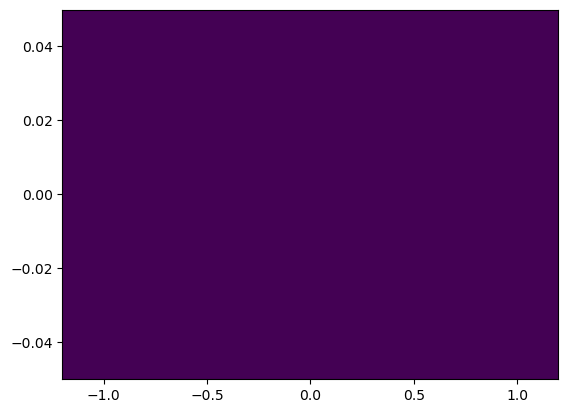

In [4]:
# Casting yt data into numpy data to analyze
# Defining analysis box limits (in code units of x and y)
xminbox, xmaxbox = -1.2, 1.2
yminbox, ymaxbox = -0.05, 0.050

# Creating the covering grid using YT to cast yt data
max_level = input_params["refinement1_level"]   # Max refinement level - highest resolution needed for numpy array
xmin, xmax = input_params["mesh_x1min"], input_params["mesh_x1max"] # This is the dimension of the WHOLE simulation domain
ymin, ymax = input_params["mesh_x2min"], input_params["mesh_x2max"]

level = max_level
Nx = input_params["mesh_nx1"] * 2**(level)  # Nx, Ny is the number of cells in each direction of the WHOLE simulation domain
Ny = input_params["mesh_nx2"] * 2**(level)

dx, dy = (xmax - xmin)/Nx, (ymax - ymin)/Ny     # grid resolution at highest refinement level
iN, jN = int(np.floor((xmaxbox - xminbox)//dx)), int(np.floor((ymaxbox - yminbox)//dy))   # Length of the covering grid data in x/y

# Finally the real covering grid:
cg = ds.covering_grid(level=level, left_edge=[xminbox, yminbox, 0], dims=[iN, jN, 1], num_ghost_zones=1)

rho = cg["gas", "density"][:,:,0].v
Bx = cg['gas', 'magnetic_field_x'][:,:,0].v
By = cg['gas', 'magnetic_field_y'][:,:,0].v
dBydx = cg["gas", "magnetic_field_y_gradient_x"][:,:,0].v
dBxdy = cg["gas", "magnetic_field_x_gradient_y"][:,:,0].v

curlB = dBydx - dBxdy

X, Y = np.reshape(cg["athena_pp","x"].v, (iN, jN)), np.reshape(cg["athena_pp","y"].v, (iN, jN))

plt.pcolormesh(X, Y, curlB)